<a href="https://colab.research.google.com/github/kiran20v/python/blob/master/Behaviour_cloning_NewTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 33.84 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [0]:
!ls

sample_data  track


In [0]:
!pip install imgaug

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from  sklearn.utils import shuffle
from  sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [0]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [0]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


-1.0

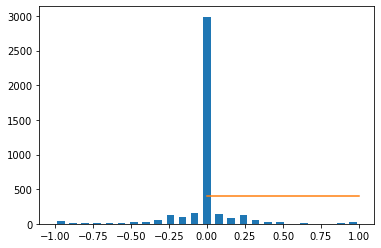

In [0]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot(np.min(data['steering']), np.max(data['steering']),(samples_per_bin, samples_per_bin))
np.min(data['steering'])

In [0]:
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
    bin_list = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            bin_list.append(i)
    bin_list = shuffle(bin_list)
    bin_list = bin_list[samples_per_bin:]
    remove_list.extend(bin_list)

print('removed',len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

total data:  4053
removed 2590
remaining:  1463


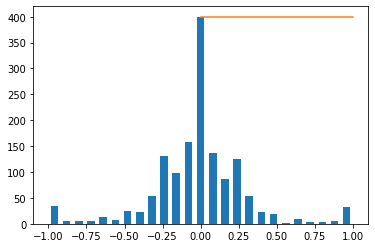

In [0]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot(np.min(data['steering']), np.max(data['steering']),(samples_per_bin, samples_per_bin))

In [0]:
print(data.iloc[1])

In [0]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right, = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training samples: ',len(X_train), len(X_valid), len(y_train), len(y_valid));

Training samples:  3511 878 3511 878


Text(0.5, 1.0, 'Validation set')

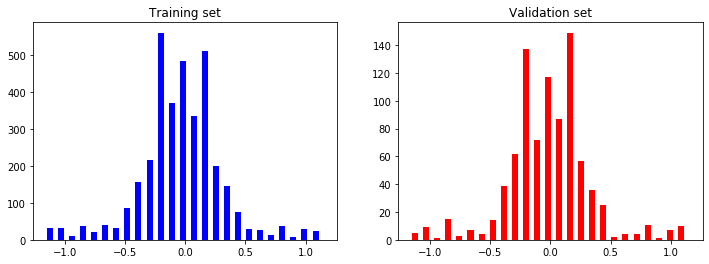

In [0]:
fig,axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(y_train, bins=num_bins, width = 0.05, color='blue')
axs[0].set_title('Training set')
axs[1].hist(y_valid, bins=num_bins, width = 0.05, color='red')
axs[1].set_title('Validation set')

In [0]:
def zoom(img):
    zoom = iaa.Affine(scale=(1, 1.3))
    img = zoom.augment_image(img)
    return img

Text(0.5, 1.0, 'zoomed_image image')

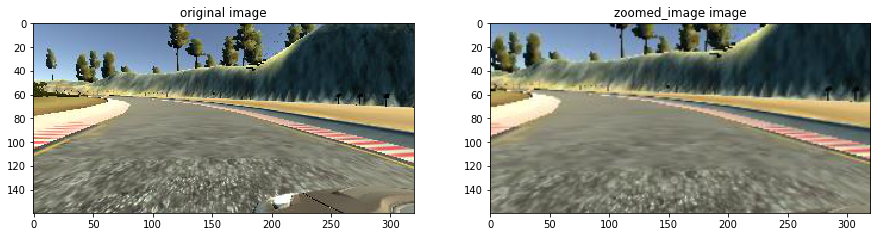

In [0]:
image_path = image_paths[random.randint(0, 650 )]
original_image = mpimg.imread(image_path)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed_image image')

In [0]:
def pan(img):
    pan = iaa.Affine(translate_percent={'x': (-0.1,0.1), 'y': (-0.1,0.1)})
    img = pan.augment_image(img)
    return img

Text(0.5, 1.0, 'panned image')

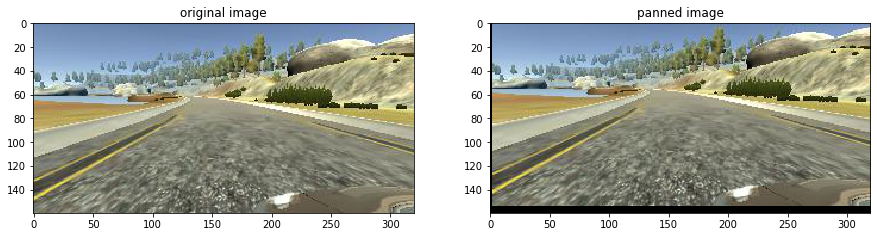

In [0]:
image_path = image_paths[random.randint(0, 650 )]
original_image = mpimg.imread(image_path)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(panned_image)
axs[1].set_title('panned image')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = - steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'panned image, angle: 0.2')

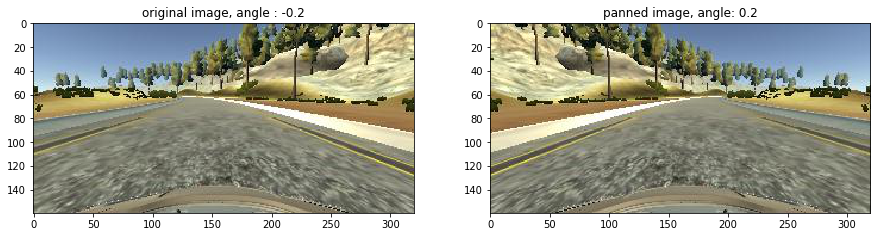

In [0]:
rand_index = random.randint(0, 650);
image_path = image_paths[rand_index]
steering = steerings[rand_index]
original_image = mpimg.imread(image_path)

flip_image, flip_steering = img_random_flip(original_image, steering)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('original image, angle : '+str(steering))
axs[1].imshow(flip_image)
axs[1].set_title('panned image, angle: '+str(flip_steering))

In [0]:
def img_random_brightness(img):
    brightness = iaa.Multiply((0.2, 1.2))
    img = brightness.augment_image(img)
    return img

Text(0.5, 1.0, 'bright image')

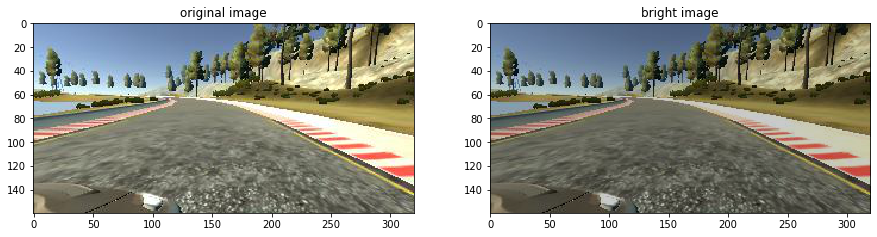

In [0]:
image_path = image_paths[random.randint(0, 650 )]
original_image = mpimg.imread(image_path)
bright_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(bright_image)
axs[1].set_title('bright image')

In [0]:
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        # print('panning')
        image = pan(image)
    if np.random.rand() < 0.5:
        # print('zooming')
        image = zoom(image)
    if np.random.rand() < 0.5:
        # print('brightenning')
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        # print('flipping')
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

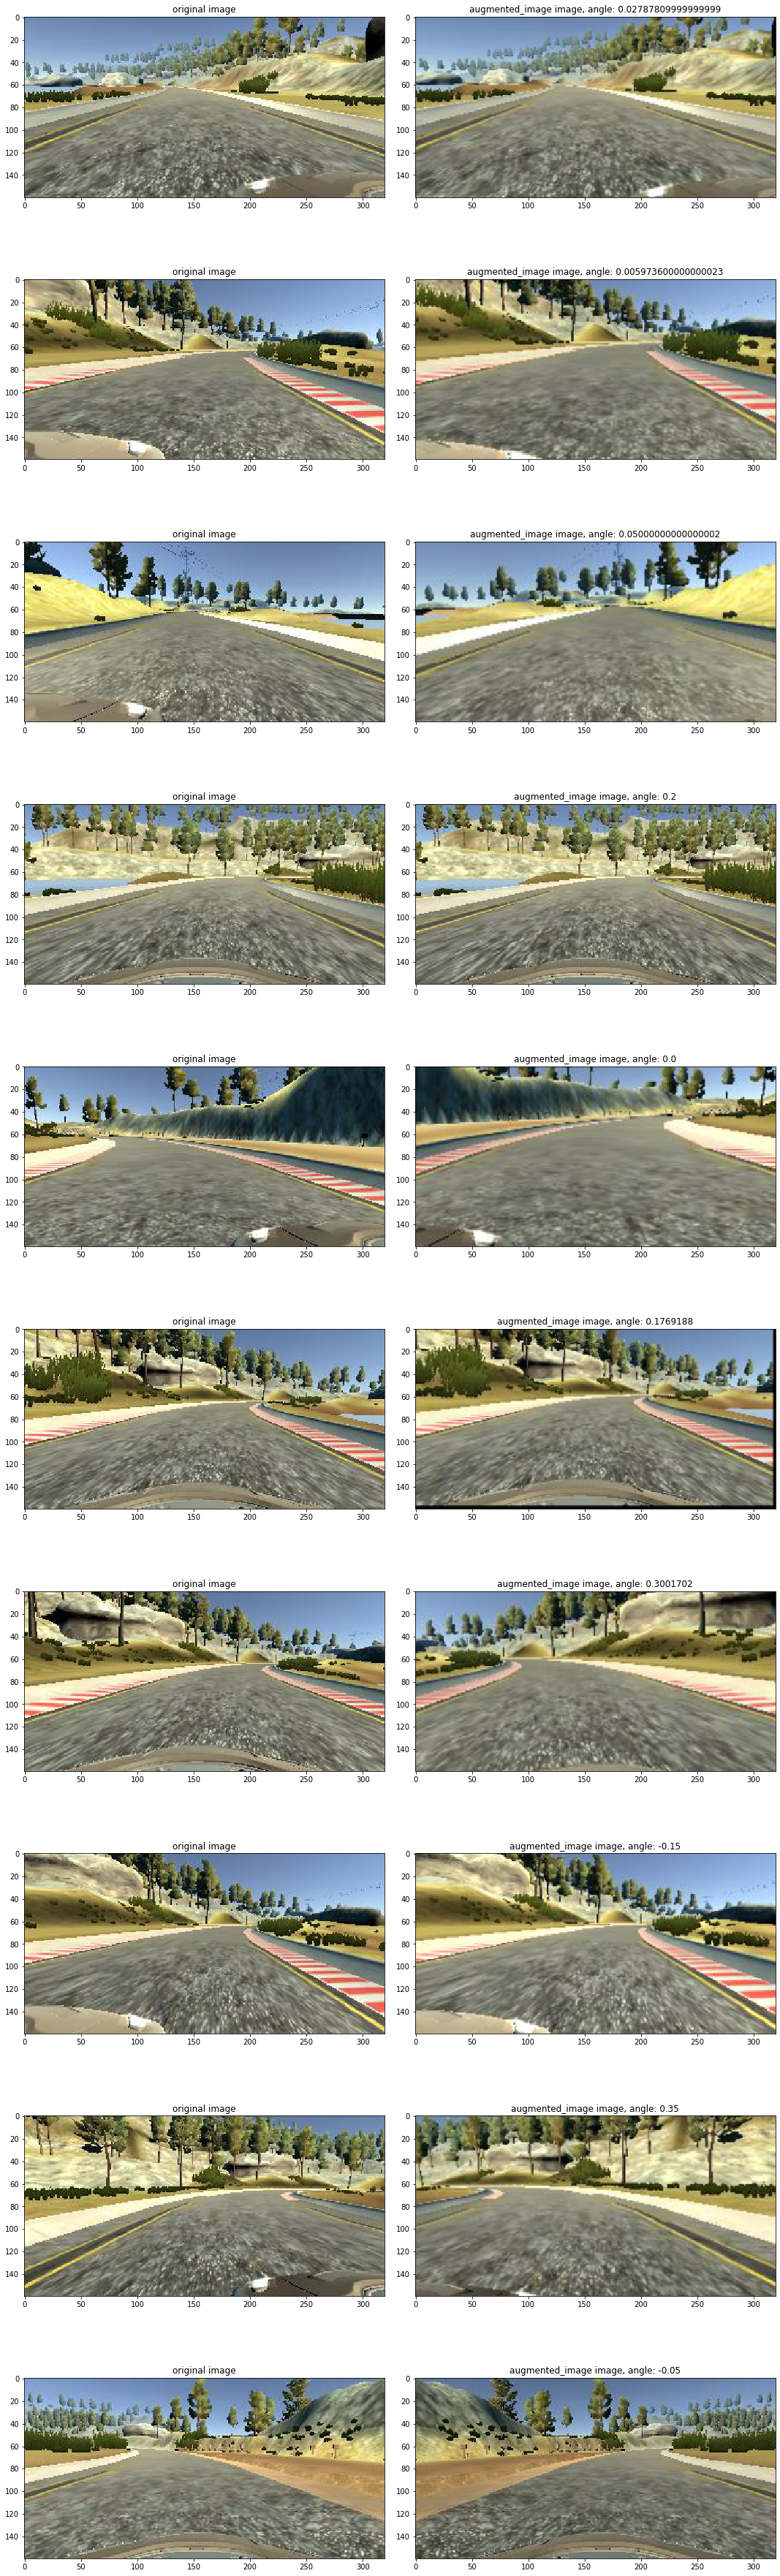

In [0]:
ncol =2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
    randNum = random.randint(0, len(image_paths)-1)
    randImage = image_paths[randNum]
    randSteering = steerings[randNum]

    original_image= mpimg.imread(randImage)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('original image')

    augmented_image, steering = random_augment(original_image, randSteering)


    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('augmented_image image, angle: '+str(randSteering))

In [0]:
def img_preprocess(img):
    img = img[60:135, :, :] # strip top and bottom
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0) # 3x3 Kernal, 0-deviation
    img = cv2.resize(img, (200, 66)) # 200x66 - Matches NVIDEA
    img = img / 255
    return img

Text(0.5, 1.0, 'preprocessed image')

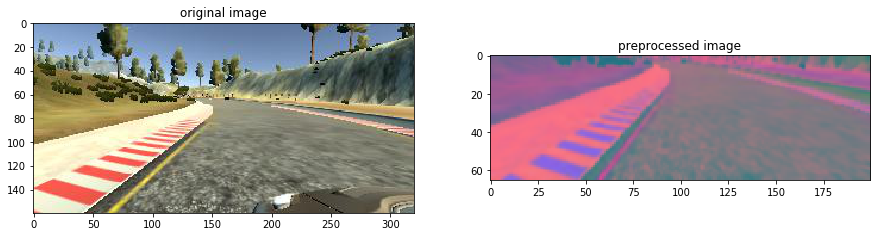

In [0]:
image_path = image_paths[100]
original_image = mpimg.imread(image_path)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
# fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed image')

In [0]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
# plt.imshow(X_train[random.randint(0, len(X_train) -1 )])
# plt.axis('off')
# print(X_train.shape)

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths)-1)
            im = mpimg.imread(image_paths[random_index])

            if istraining:
                im, steering = random_augment(im, steering_ang[random_index])
            else:
                steering = steering_ang[random_index] 

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.array(batch_steering))

Text(0.5, 1, 'Validation image')

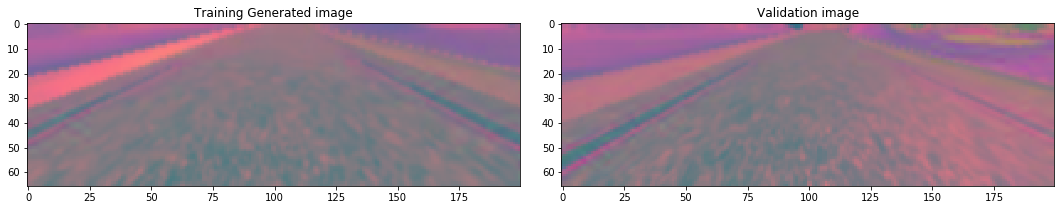

In [0]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Generated image')

axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation image')

In [0]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66, 200, 3), activation='relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    # model.add(Dropout(0.5))
   
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    # model.add(Dropout(0.5))
   
    model.add(Dense(50, activation='elu'))
    # model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(lr=1e-4))
    return model

In [0]:
model = nvidia_model()
print(model.summary)

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300, 
                              epochs=10, 
                              validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps=200, 
                              verbose=1, 
                              shuffle=1)




Epoch 1/10





300/300 [==============================] - 171s 571ms/step - loss: 0.0873 - val_loss: 0.0614
Epoch 2/10
300/300 [==============================] - 164s 546ms/step - loss: 0.0630 - val_loss: 0.0504
Epoch 3/10
300/300 [==============================] - 163s 544ms/step - loss: 0.0564 - val_loss: 0.0444
Epoch 4/10
300/300 [==============================] - 164s 545ms/step - loss: 0.0533 - val_loss: 0.0408
Epoch 5/10
300/300 [==============================] - 164s 545ms/step - loss: 0.0511 - val_loss: 0.0365
Epoch 6/10
300/300 [==============================] - 167s 557ms/step - loss: 0.0487 - val_loss: 0.0375
Epoch 7/10
300/300 [==============================] - 166s 554ms/step - loss: 0.0465 - val_loss: 0.0339
Epoch 8/10
300/300 [==============================] - 169s 562ms/step - loss: 0.0455 - val_loss: 0.0344
Epoch 9/10
300/300 [==============================] - 164s 547ms/step - loss: 0.0441 - val_loss: 0.0341
Epoch 10/10
300/300 [==============================] - 1

Text(0.5, 1.0, 'loss')

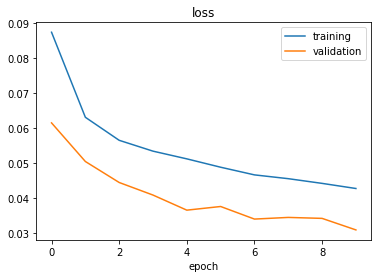

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.title('loss')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')